In [29]:
from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils,
    constants
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import signal
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [3]:
params = dict(
    experiment_dir=Path("/Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/"),
    imaging_scheme="TL/470/410/470/410",
    register=False
)

ex_unreg = experiment.PairExperiment(**params).full_pipeline()
# ex_reg = experiment.PairExperiment(**params, should_register=True).full_pipeline()

01:12:22 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
01:12:22 INFO:Segmenting pharynxes
01:12:24 INFO:Centering and rotating pharynxes


01:12:33 INFO:Calculating midlines


01:12:34 INFO:Measuring under midlines


01:12:35 INFO:Trimming intensity data


01:12:36 INFO:Calculating redox measurements
/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
01:12:36 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
01:12:36 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-26_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
01:12:37 INFO:Saving untrimmed profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-26_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-untrimmed_profile_data.nc
01:12:37 INFO:Saving trimmed profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-26_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-tri

In [6]:
idx = 90
stationary_pair = 1
moving_pair = 0

# stationary
i410_stationary = ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=stationary_pair)[idx]
i470_stationary = ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=stationary_pair)[idx]
s410_stationary = profile_processing.smooth_profile_data(i410_stationary, smoothing_parameter=1e-6)
s470_stationary = profile_processing.smooth_profile_data(i470_stationary, smoothing_parameter=1e-6)

# moving
i410_moving = ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=moving_pair)[idx]
i470_moving = ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=moving_pair)[idx]
s410_moving = profile_processing.smooth_profile_data(i410_moving, smoothing_parameter=1e-6)
s470_moving = profile_processing.smooth_profile_data(i470_moving, smoothing_parameter=1e-6)

01:16:35 WARNING:No handles with labels found to put in legend.
/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


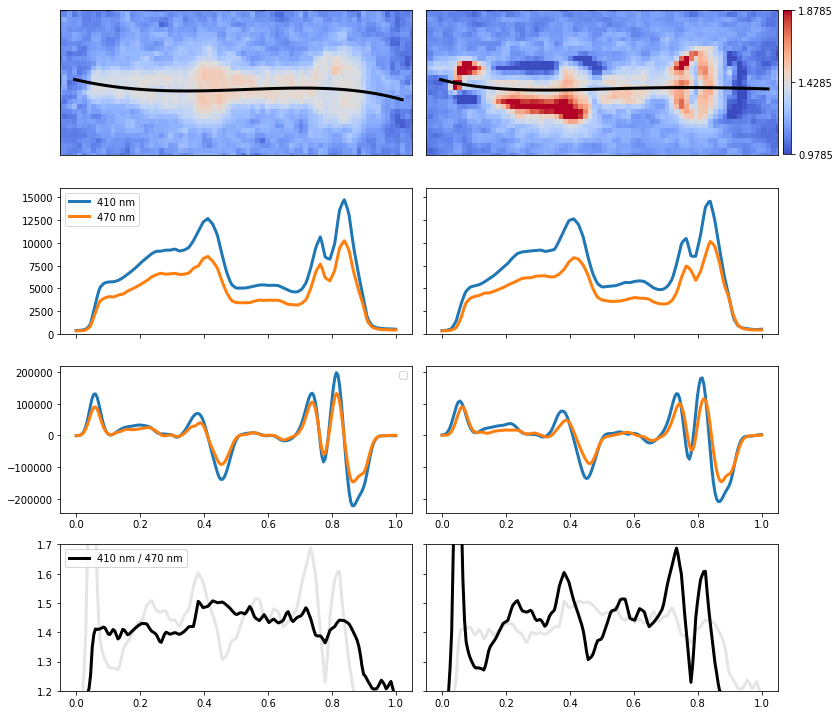

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

font = {'size'   : 10}

matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=False)

fig, axes = plt.subplots(4,2, sharey='row', figsize=(11, 10))


midline_color = 'black'
midline_width = 3
profile_linewidth = 3

r_center = np.mean(
    (ex_unreg.trimmed_profiles.sel(wavelength='410', pair=stationary_pair)[idx] /
    ex_unreg.trimmed_profiles.sel(wavelength='470', pair=stationary_pair)[idx])
)
r_range = 0.45

ax= axes[0, 1]
im = ax.imshow(
    (ex_unreg.rot_fl.sel(wavelength='410', pair=moving_pair)[idx] /
    ex_unreg.rot_fl.sel(wavelength='470', pair=moving_pair)[idx]),
    aspect='equal',
    clim=(1,1.6),
    cmap='coolwarm',
    vmin=r_center-r_range,
    vmax=r_center+r_range,
)
# COLORBAR
ax_bbox = ax.get_position()
pad = 0.17
cbar_w = .01
cax = fig.add_axes([ax_bbox.xmax+pad, ax_bbox.ymin+.068, cbar_w, .2])
cax.yaxis.set_ticks_position('right')
cbar = plt.colorbar(im, cax=cax, ticks=[r_center-r_range, r_center, r_center+r_range])

ax.plot(*ex_unreg.midlines[idx]['410'][stationary_pair].linspace(), color=midline_color, linewidth=midline_width)
ax.set_xlim(47, 120)
ax.set_ylim(50, 80)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = axes[0,0]
im = ax.imshow(
    (ex_unreg.rot_fl.sel(wavelength='410', pair=stationary_pair)[idx] /
    ex_unreg.rot_fl.sel(wavelength='470', pair=stationary_pair)[idx]),
    aspect='equal',
    clim=(1,1.6),
    cmap='coolwarm',
    vmin=r_center-r_range,
    vmax=r_center+r_range,
)
ax.plot(*ex_unreg.midlines[idx]['410'][moving_pair].linspace(), color=midline_color, linewidth=midline_width)
ax.set_xlim(47, 120)
ax.set_ylim(50, 80)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# INTENSITY
xs = np.linspace(0, 1, 200)
# vline_xs = [0.41, 0.764, 0.84]
# for x in vline_xs:
#     axes[1,0].axvline(x, color='lightgray')

axes[1,0].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=stationary_pair)[idx], label='410 nm', linewidth=profile_linewidth)
axes[1,0].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=stationary_pair)[idx], label='470 nm', linewidth=profile_linewidth)

# vline_xs = [0.41, 0.764, 0.84]
# for x in vline_xs:
#     axes[1,1].axvline(x, color='lightgray')
axes[1,1].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=moving_pair)[idx], linewidth=profile_linewidth)
axes[1,1].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=moving_pair)[idx], linewidth=profile_linewidth)
axes[1,0].legend(loc='upper left')

plt.setp(axes[1,0].get_xticklabels(), visible=False)
plt.setp(axes[1,1].get_xticklabels(), visible=False)
axes[1,0].set_ylim(0, 16000)
axes[1,1].set_ylim(0, 16000)

# DERIVATIVES
# stationary
xs = np.linspace(0, 1, 200)
axes[2,0].plot(xs, np.squeeze(s410_stationary[0].derivative()(xs)), linewidth=profile_linewidth)
axes[2,0].plot(xs, np.squeeze(s470_stationary[0].derivative()(xs)), linewidth=profile_linewidth)
axes[2,0].legend()

# moving
xs = np.linspace(0, 1, 200)
axes[2,1].plot(xs, np.squeeze(s410_moving[0].derivative()(xs)), linewidth=profile_linewidth)
axes[2,1].plot(xs, np.squeeze(s470_moving[0].derivative()(xs)), linewidth=profile_linewidth)

# RATIOS
xs = np.linspace(0, 1, 200)
axes[3,0].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='r', pair=stationary_pair)[idx], color='k', label='410 nm / 470 nm', linewidth=profile_linewidth)
axes[3,0].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='r', pair=moving_pair)[idx], color='k', alpha=0.1, linewidth=profile_linewidth)
axes[3,0].legend(loc='upper left')
axes[3,1].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='r', pair=moving_pair)[idx], color='k', linewidth=profile_linewidth)
axes[3,1].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='r', pair=stationary_pair)[idx], color='k', alpha=0.1, linewidth=profile_linewidth)
axes[3,1].set_ylim(1.2,1.7)

plt.tight_layout()
# plt.savefig('~/Desktop/testing.pdf')

# Registration Figures

In [279]:
meta_dir = Path("/Users/sean/code/pharynx_redox/data/paired_ratio/")

prof_raw = da.load_all_cached_profile_data(meta_dir, '**/*new_idx_regionwise/*untrimmed_profile_data.nc')
        prof_reg = da.load_all_cached_profile_data(meta_dir, '**/*reg_w1e-3/*untrimmed_profile_data.nc')
prof_reg_old = da.load_all_cached_profile_data(meta_dir, '**/*matlab_reg/*untrimmed_profile_data-reindexed.nc')

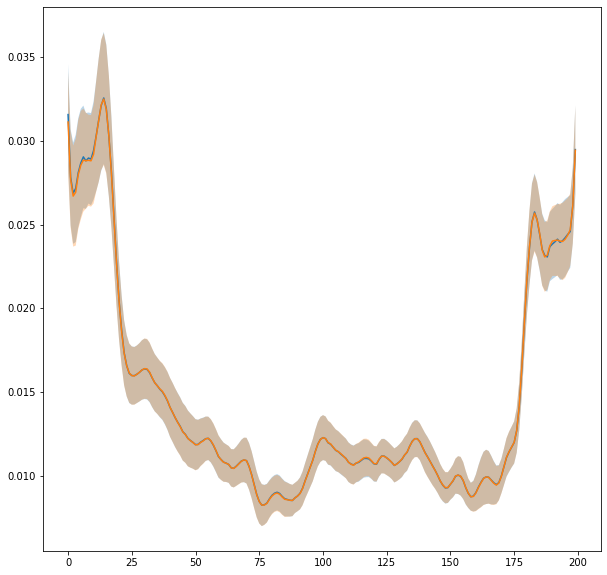

In [280]:
fig, ax = plt.subplots(figsize=(10,10))
plots.plot_profile_avg_with_bounds(da.fold_error(prof_reg), ax=ax)
plots.plot_profile_avg_with_bounds(da.fold_error(prof_reg_old.sel(spec=prof_reg.spec)), ax=ax)

In [275]:
m_0_0, m_0_1, m_1_0, m_1_1 = da.split_by_movement_types(da.mvmt_long_to_wide(da.load_all_movement(meta_dir)), 'posterior')
regions = utils.scale_region_boundaries(constants.untrimmed_regions, 200)

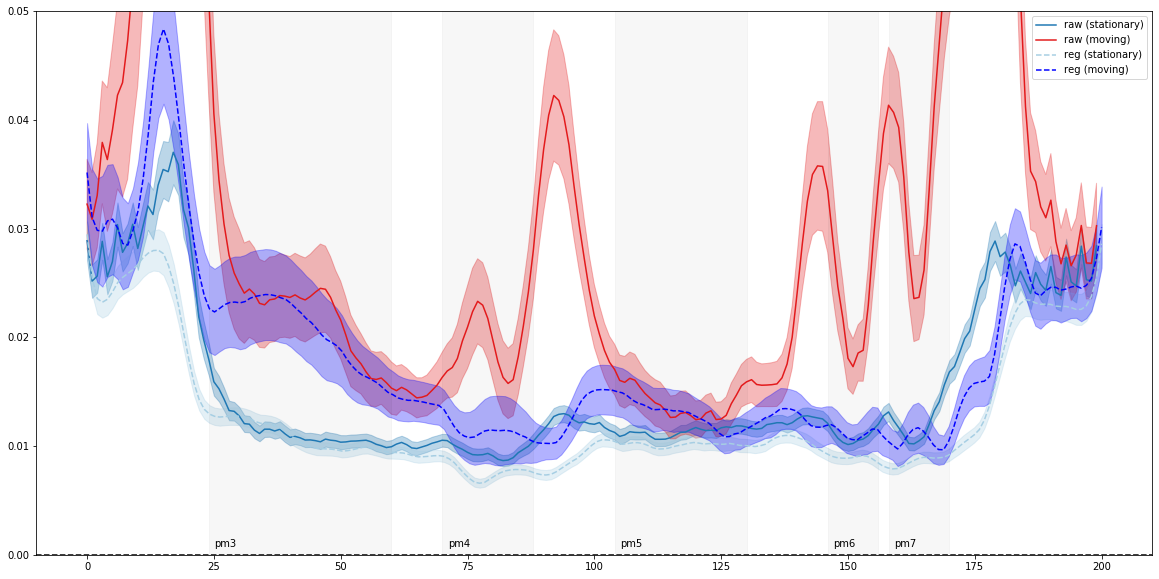

In [278]:
reload(da);
reload(plots);
fig, ax = plt.subplots(figsize=(20,10))

cmap = plt.get_cmap('Paired').colors

prof_raw_stationary = prof_raw.sel(spec=m_0_0.index)
prof_raw_moving = xr.concat([prof_raw.sel(spec=m_0_1.index), prof_raw.sel(spec=m_1_0.index)], dim='spec')

prof_reg_stationary = prof_reg.sel(spec=m_0_0.index)
prof_reg_moving = xr.concat([prof_reg.sel(spec=m_0_1.index), prof_reg.sel(spec=m_1_0.index)], dim='spec')


plots.plot_profile_avg_with_bounds(da.fold_error(prof_raw_stationary), ax=ax, label='raw (stationary)', color=cmap[1])
plots.plot_profile_avg_with_bounds(da.fold_error(prof_raw_moving), ax=ax, label='raw (moving)', color=cmap[5])

plots.plot_profile_avg_with_bounds(da.fold_error(prof_reg_stationary), ax=ax, label='reg (stationary)', xs=np.linspace(0,200,prof_reg_stationary.shape[-1]), color=cmap[0], linestyle='--')
plots.plot_profile_avg_with_bounds(da.fold_error(prof_reg_moving), ax=ax, label='reg (moving)', xs=np.linspace(0,200,prof_reg_moving.shape[-1]), color='blue', linestyle='--')


plots.add_regions_to_axis(ax, regions, label_dist_bottom_percent=0.015)
ax.legend()
ax.axhline(0, linestyle='--', color='k')
ax.set_ylim(0,.05);

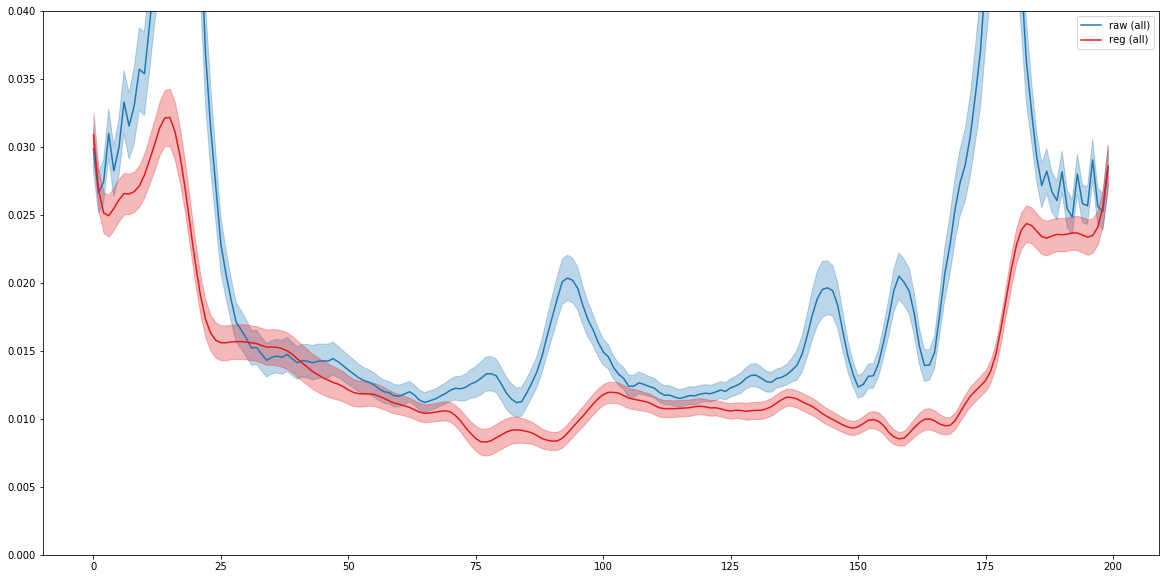

In [36]:
fig, ax = plt.subplots(figsize=(20,10))

plots.plot_profile_avg_with_bounds(da.fold_error(prof_raw), ax=ax, label='raw (all)', color=cmap[1])
plots.plot_profile_avg_with_bounds(da.fold_error(prof_reg), ax=ax, label='reg (all)', color=cmap[5])
ax.legend();
ax.set_ylim(0,0.04);

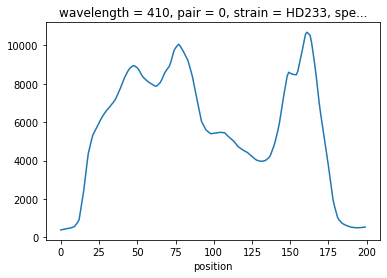

In [69]:
prof_raw.sel(wavelength='410', pair=0)[0].plot()

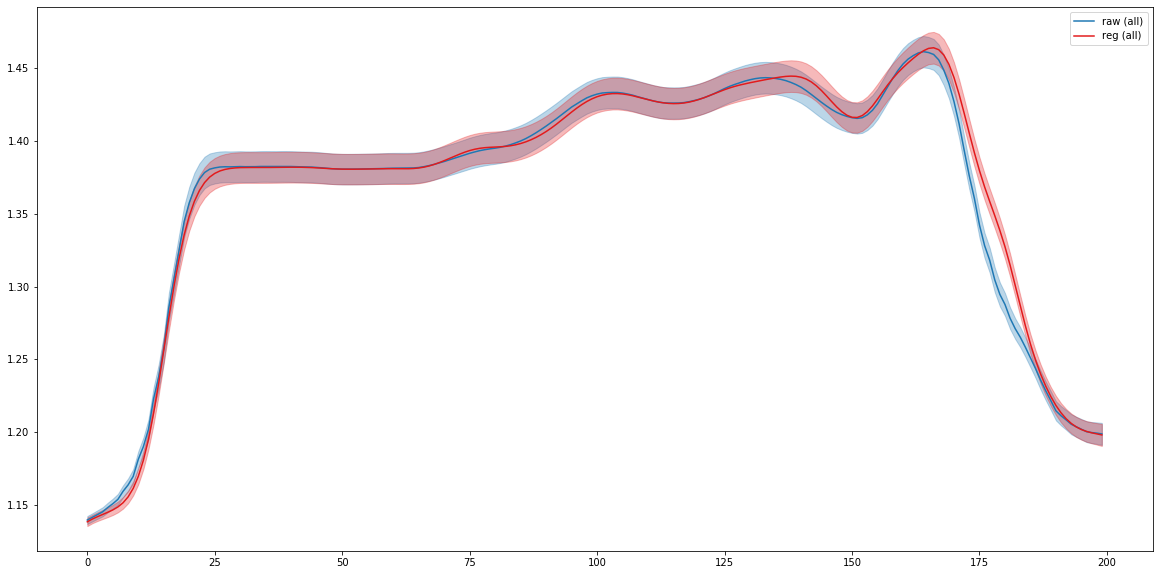

In [38]:
fig, ax = plt.subplots(figsize=(20,10))

plots.plot_profile_avg_with_bounds(prof_raw.sel(wavelength='r').mean(dim='pair'), ax=ax, label='raw (all)', color=cmap[1])
reg_r = prof_reg.sel(wavelength='410') / prof_reg.sel(wavelength='470')
plots.plot_profile_avg_with_bounds(reg_r.mean(dim='pair'), ax=ax, label='reg (all)', color=cmap[5])
ax.legend();
# ax.set_ylim(0,0.04);

In [86]:
m_idx = pd.concat([m_0_1, m_0_1]).index
s_idx = m_0_0.index

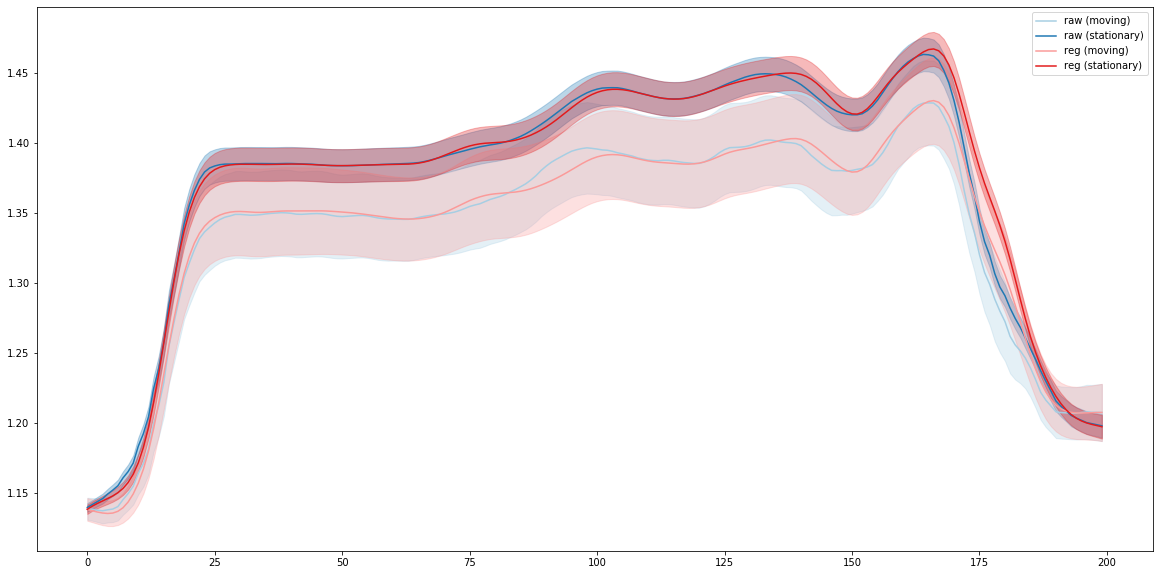

In [89]:
fig, ax = plt.subplots(figsize=(20,10))

plots.plot_profile_avg_with_bounds(prof_raw.sel(spec=m_idx, wavelength='r').mean(dim='pair'), ax=ax, label='raw (moving)', color=cmap[0])
plots.plot_profile_avg_with_bounds(prof_raw.sel(spec=s_idx, wavelength='r').mean(dim='pair'), ax=ax, label='raw (stationary)', color=cmap[1])
reg_r = prof_reg.sel(wavelength='410') / prof_reg.sel(wavelength='470')
plots.plot_profile_avg_with_bounds(reg_r.sel(spec=m_idx).mean(dim='pair'), ax=ax, label='reg (moving)', color=cmap[4])
plots.plot_profile_avg_with_bounds(reg_r.sel(spec=s_idx).mean(dim='pair'), ax=ax, label='reg (stationary)', color=cmap[5])
ax.legend();
# ax.set_ylim(0,0.04);

In [201]:
prof_raw

<xarray.DataArray (spec: 863, wavelength: 5, pair: 2, position: 200)>
array([[[[ 3.19000000e+02,  3.35000000e+02,  3.52000000e+02, ...,
           4.66000000e+02,  4.82000000e+02,  4.99000000e+02],
         [ 2.93000000e+02,  2.99000000e+02,  3.05000000e+02, ...,
           4.86000000e+02,  5.00000000e+02,  5.14000000e+02]],

        [[ 3.85000000e+02,  4.03000000e+02,  4.21000000e+02, ...,
           5.15000000e+02,  5.24000000e+02,  5.33000000e+02],
         [ 3.34000000e+02,  3.44000000e+02,  3.53000000e+02, ...,
           5.64000000e+02,  5.73000000e+02,  5.83000000e+02]],

        [[ 1.20689655e+00,  1.20298507e+00,  1.19602273e+00, ...,
           1.10515021e+00,  1.08713693e+00,  1.06813627e+00],
         [ 1.13993174e+00,  1.15050167e+00,  1.15737705e+00, ...,
           1.16049383e+00,  1.14600000e+00,  1.13424125e+00]],

        [[ 2.76040752e-01,  2.73688658e-01,  2.69472417e-01, ...,
           2.10726796e-01,  1.98195889e-01,  1.84631656e-01],
         [ 2.34061652e-01,  

In [221]:
d.experiment.values

array(['2017_02_22-HD233_SAY47', '2017_02_23-HD233_HD236',
       '2017_02_27-HD233_HD236', '2017_03_01_HD233_HD236',
       '2017_08_15-HD233_4mM_lev', '2017_08_23-HD233_4mm_lev',
       '2017_08_24-HD233_SAY93', '2017_08_25-HD233_4mm_lev',
       '2017_08_25-HD233_SAY93', '2019_04_03-ASI_ablation'], dtype=object)

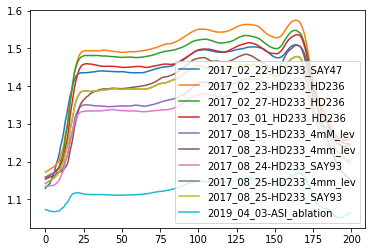

In [224]:
d = prof_raw.sel(wavelength='r').groupby('experiment').mean(dim=['spec', 'pair'])
for i in range(d.shape[0]):
    plt.plot(d[i], label=d.experiment.values[i])
plt.legend();

In [196]:
prof_raw = da.load_all_cached_profile_data(meta_dir, '**/*new_idx_regionwise/*untrimmed_profile_data.nc')
prof_reg = da.load_all_cached_profile_data(meta_dir, '**/*matlab_reg/*untrimmed_profile_data-reindexed.nc')

# prof_raw = prof_raw.sel(experiment=prof_raw.experiment.values[0], drop=False)
# prof_reg = prof_reg.sel(experiment=prof_reg.experiment.values[0], drop=False)

prof_raw.sel(experiment='2017_02_22-HD233_SAY47', drop=False).coords

Coordinates:
  * wavelength  (wavelength) object '470' '410' 'r' 'oxd' 'e'
  * position    (position) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * pair        (pair) int64 0 1
    strain      (animal) object 'HD233' 'HD233' 'HD233' ... 'SAY47' 'SAY47'
  * animal      (animal) int64 0 1 2 3 4 5 6 7 ... 116 117 118 119 120 121 122

In [182]:
reload(plots);
prof_raw = da.load_all_cached_profile_data(meta_dir, '**/*new_idx_regionwise/*untrimmed_profile_data.nc')
prof_reg = da.load_all_cached_profile_data(meta_dir, '**/*matlab_reg/*untrimmed_profile_data-reindexed.nc')

prof_raw = prof_raw.sel(experiment=prof_raw.experiment.values[0], drop=False)
prof_reg = prof_reg.sel(experiment=prof_reg.experiment.values[0], drop=False)

r_a = prof_raw.sel(wavelength='r',pair=0)
r_s = prof_raw.sel(wavelength='r',pair=0, spec=s_idx)
r_m = prof_raw.sel(wavelength='r',pair=0, spec=m_idx)
r_mm = prof_raw.sel(wavelength='r',pair=0, spec=m_1_1.index)

r_reg_a = prof_reg.sel(wavelength='410', pair=0) / prof_reg.sel(wavelength='470', pair=0)
r_reg_s = prof_reg.sel(wavelength='410', pair=0, spec=s_idx) / prof_reg.sel(wavelength='470',pair=0, spec=s_idx)
r_reg_m = prof_reg.sel(wavelength='410', pair=0, spec=m_idx) / prof_reg.sel(wavelength='470',pair=0, spec=m_idx)

fig, axes = plt.subplots(2,1,figsize=(10,10))

plots.plot_profile_avg_with_bounds((r_s - r_s.mean(dim='position')), ax=axes[0], label='raw (stationary)', color='k')
plots.plot_profile_avg_with_bounds((r_m - r_m.mean(dim='position')), ax=axes[0], label='raw (moving)')
plots.plot_profile_avg_with_bounds((r_a - r_a.mean(dim='position')), ax=axes[0], label='raw (all)')

plots.plot_profile_avg_with_bounds((r_reg_s - r_reg_s.mean(dim='position')), ax=axes[1], label='reg (stationary)', color='k')
plots.plot_profile_avg_with_bounds((r_reg_a - r_reg_a.mean(dim='position')), ax=axes[1], label='reg (all)')
plots.plot_profile_avg_with_bounds((r_reg_m - r_reg_m.mean(dim='position')), ax=axes[1], label='reg (moving)', color='tab:red')

axes[0].set_ylim(0, 0.1)
axes[1].set_ylim(0, 0.1)

axes[0].set_xlim(20, 175)
axes[1].set_xlim(20, 175)

axes[0].legend();
axes[1].legend();

ValueError: dimensions or multi-index levels ['spec'] do not exist